In [20]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Optional
from itertools import product
import matplotlib.dates as mdates
import datetime

In [100]:
DATA = Path("..","data","processed")
SECTORS = ["E", "H", "EH"]
PRICES = ["vlow", "low", "mid", "high"]
EMISSIONS = ["20", "35", "50"]
EMISSION_NICE_NAMES = {
    "er20":r"20% Emission Reduction",
    "er35":r"35% Emission Reduction",
    "er50":r"50% Emission Reduction",
}
SECTOR_NICE_NAMES = {
    "E": "Electrical",
    "H": "Thermal",
    "EH": "Electrical and Thermal"
}
PRICE_NICE_NAMES = {
    "vlow": "Very Low",
    "low": "Low",
    "mid": "Mid",
    "high": "High"
}

In [127]:
def get_dataframe(emission: str, result: str, sector: Optional[str] = None, price: Optional[str] = None) -> pd.DataFrame:
    if not (sector or price):
        scenario = f"er{emission}"
    else:
        scenario = f"{sector}dr-{price}-er{emission}" 
    p = Path(DATA, scenario, "datapoint", f"{result}.csv")
    return pd.read_csv(p, index_col=0)

In [126]:
def get_season(season_type: str, emission: str, sector: Optional[str] = None, price: Optional[str] = None) -> dict[str, datetime.date]:
    
    if season_type == "shed":
        df = get_dataframe(emission=emission, sector=sector, price=price, result="shed_season")
    elif season_type == "shift":
        df = get_dataframe(emission=emission, sector=sector, price=price, result="shift_season")
    else:
        raise ValueError(f"Expected one of ['shift', 'shed']. Recieved {season_type}")
        
    df["value"] = pd.to_datetime(df.value)
    
    return {
        "start": df.at["first_day", "value"].date(),
        "end": df.at["last_day", "value"].date()
    }

In [125]:
def get_data(season_type: str) -> dict[str,dict[str, str | datetime.date]]:
    """
    data = get_data()
    data[emission][price][sector]
    > {start: datetime.date, end: datetime.date}
    """
    
    data = {}
    
    for e, s, p in product(EMISSIONS, SECTORS, PRICES):

        if e not in data:
            data[e] = {}
            data[e][s] = {}
            data[e][s][p] = {}
        else: 
            if s not in data[e]:
                data[e][s] = {}
                data[e][s][p] = {}
            else:
                if p not in data[e][s]:
                    data[e][s][p] = {}
                    
        season = get_season(season_type, e, s, p)

        data[e][s][p]["start"] = season["start"]
        data[e][s][p]["end"] = season["end"]
        
    return data

In [135]:
def plot_season(season_type: str) -> tuple[plt.figure, plt.axes]:
    
    data = get_data(season_type)
    
    fig, axs = plt.subplots(len(EMISSIONS), 1, figsize=(12,16))
    
    year_start = pd.Timestamp("2030-01-01")
    year_end = pd.Timestamp("2030-12-31")
    # dates = pd.date_range(start=year_start, end=year_end, freq="D")
    
    for ax, e in enumerate(EMISSIONS):
        y_labels = []
        for i, (s, p) in enumerate(product(SECTORS, PRICES)):
            scenario = data[e][s][p]
            label = f"{s}-{p}"
            axs[ax].fill_betweenx(
                [i + 1 - 0.2, i + 1 + 0.2], 
                scenario["start"], scenario["end"], 
                color="tab:blue", alpha=0.75
            )
            # axs[ax].text(scenario["end"] + pd.Timedelta(days=3), i + 1, label, va="center")
            y_labels.append(label)
    
        axs[ax].set_title(EMISSION_NICE_NAMES[f"er{e}"])
    
        axs[ax].set_yticks(range(1, i + 2))
        axs[ax].set_yticklabels(y_labels)
        
        axs[ax].xaxis.set_major_formatter(mdates.DateFormatter("%b"))
        axs[ax].xaxis.set_major_locator(mdates.MonthLocator())
        axs[ax].set_xlim([year_start, year_end])

        axs[ax].grid(axis="x", linestyle="--", alpha=0.6)
    
    if season_type == "shift":
        fig.suptitle("Shift Season Duration", fontsize=16)
    elif season_type == "shed":
        fig.suptitle("Shed Season Duration", fontsize=16)
    
    plt.tight_layout(rect=[0, 0, 1, 0.99]) 
    
    return fig, axs

(<Figure size 1200x1600 with 3 Axes>,
 array([<Axes: title={'center': '20% Emission Reduction'}>,
        <Axes: title={'center': '35% Emission Reduction'}>,
        <Axes: title={'center': '50% Emission Reduction'}>], dtype=object))

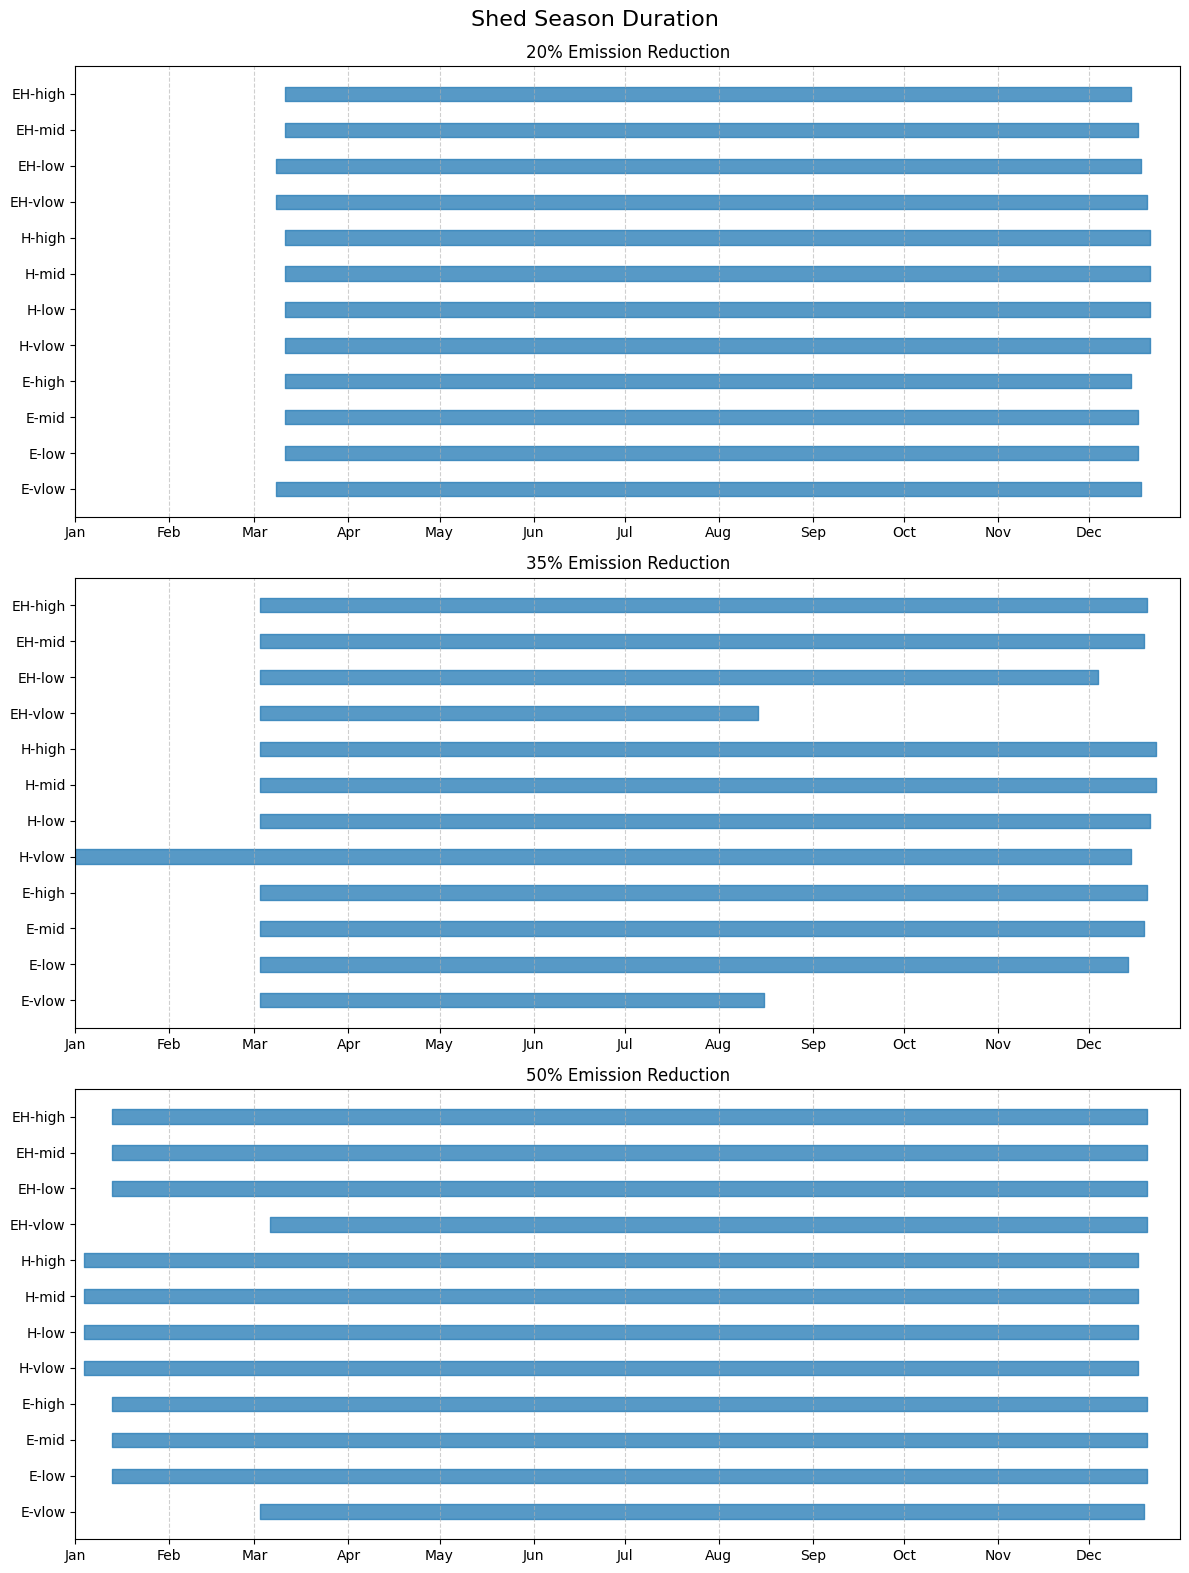

In [136]:
plot_season("shed")

(<Figure size 1200x1600 with 3 Axes>,
 array([<Axes: title={'center': '20% Emission Reduction'}>,
        <Axes: title={'center': '35% Emission Reduction'}>,
        <Axes: title={'center': '50% Emission Reduction'}>], dtype=object))

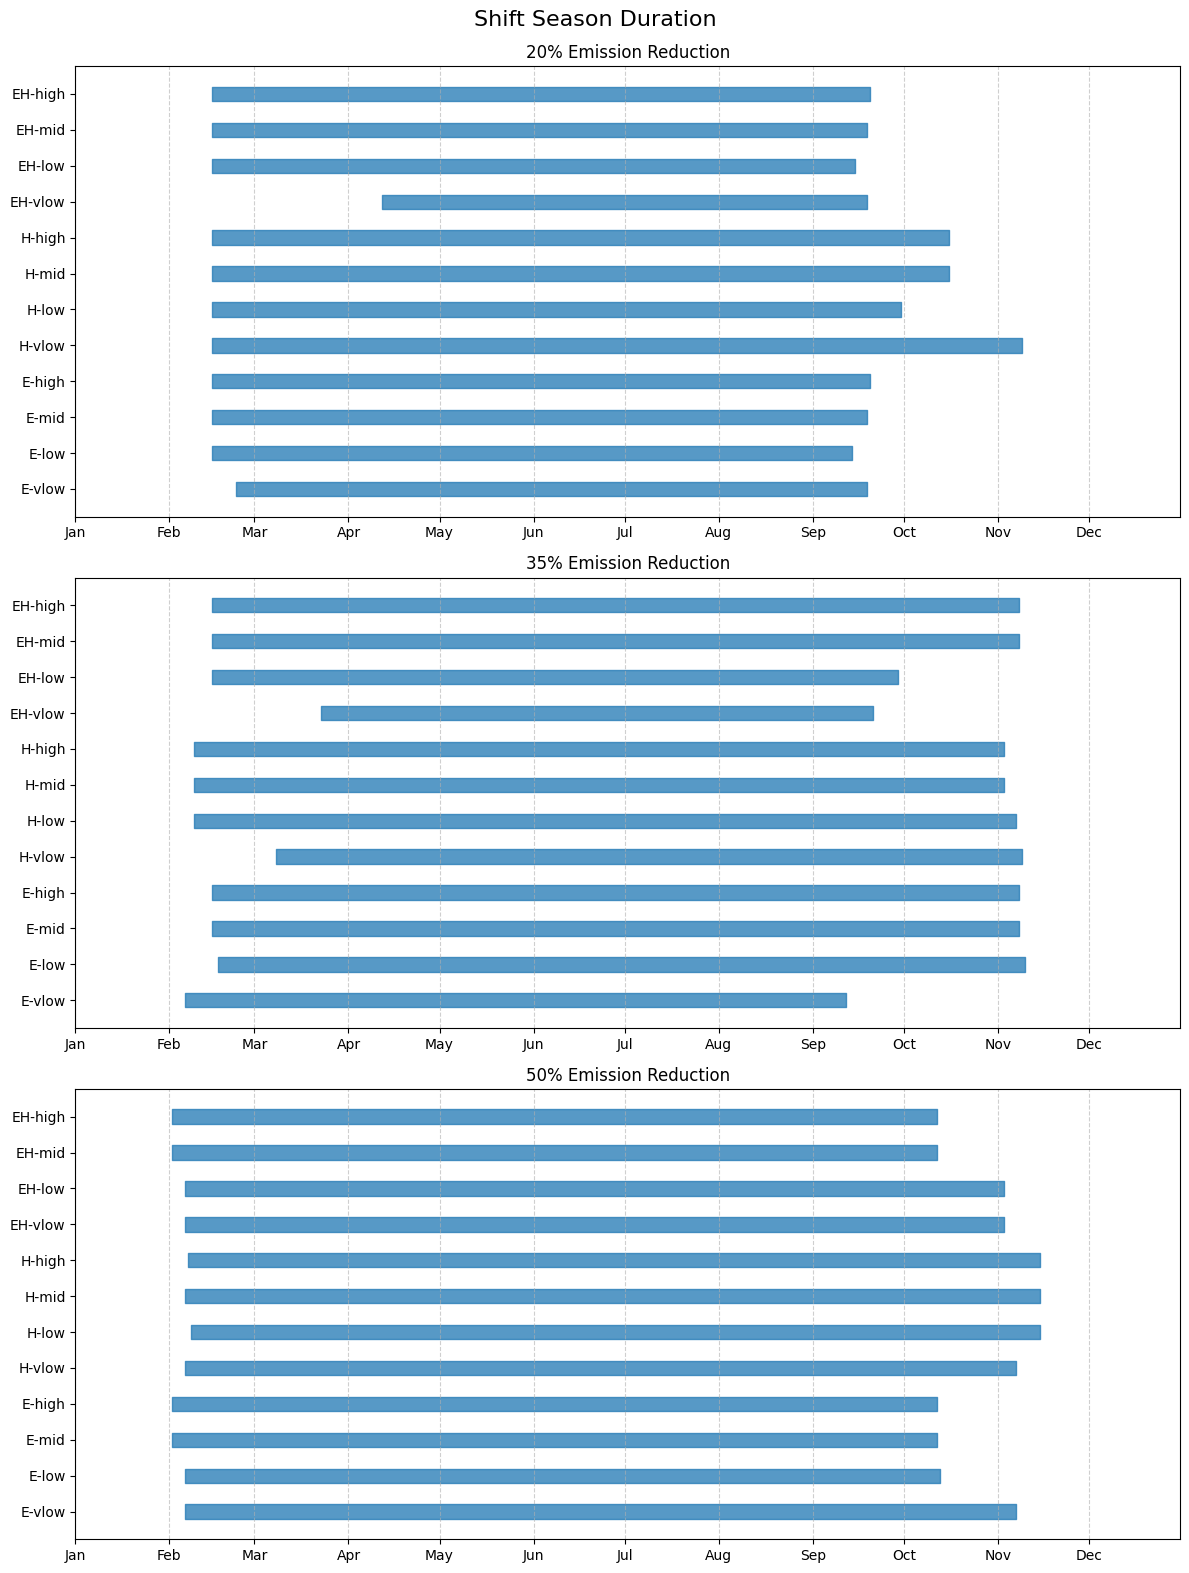

In [137]:
plot_season("shift")